# Modules

In [1]:
%load_ext autoreload
%autoreload 2

import sys

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import torch
from sklearn import datasets, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split

from torch.optim import Adam
from torch.utils.data import DataLoader

from tqdm.autonotebook import tqdm

from models.model import Neural_Net
from dataset_samplers import RandomCorruptSampler, ClassCorruptSampler, SupervisedSampler 
from training import train_contrastive_loss, train_classification
from utils import fix_seed, load_openml_list, preprocess_datasets, fit_one_hot_encoder

import warnings
warnings.filterwarnings('ignore')
print("Disabled warnings!")

seed = 1234
fix_seed(seed)

clf = LogisticRegression()

plot_colors = {
    'orig_input': 'k',
    'rand_corr': 'g',
    'cls_corr': 'r',
    'orc_corr': 'b'
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


/home/wei/anaconda3/envs/pfgen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Disabled warnings!
Using device: cuda


# Data

In [2]:
# Toy dataset
# dataset_name = 'breast_cancer'
# data = datasets.load_breast_cancer(as_frame=True)
# data, target = data["data"], data["target"]

# OpenML dataset
datasets = load_openml_list([4538, 6332])
# select one dataset to run below
dataset = datasets[0]
dataset_name, data, target = dataset

print(f"Loaded dataset: {dataset_name}, with data shape: {data.shape}, and target shape: {target.shape}")
print(f"{dataset_name} dataset has {len(data.select_dtypes(include='category').columns)}/{len(data.columns)} categorical features.")

Loading GesturePhaseSegmentationProcessed 4538 ..
Dataset with did 4538 has 0/32 categorical features.
Loading cylinder-bands 6332 ..


Dataset with did 6332 has 19/37 categorical features.
Loaded dataset: GesturePhaseSegmentationProcessed, with data shape: (9873, 32), and target shape: (9873,)
GesturePhaseSegmentationProcessed dataset has 0/32 categorical features.


In [3]:
tmp_data, test_data, tmp_target, test_target = train_test_split(
    data, 
    target, 
    test_size=0.2, 
    stratify=target, 
    random_state=seed
)

train_data, valid_data, train_target, valid_target = train_test_split(
    tmp_data,
    tmp_target,
    test_size=1/8,
    stratify=tmp_target,
    random_state=seed
)

print(f"# samples: Train: {len(train_data)}; Valid: {len(valid_data)}; Test: {len(test_data)}")
print(f"Train data with type {type(train_data)} and shape {train_data.shape}; Train target with type: {type(train_target)} and shape {train_target.shape}")
print(f"Valid data with type {type(valid_data)} and shape {valid_data.shape}; Valid target with type: {type(valid_target)} and shape {valid_target.shape}")
print(f"Test data with type {type(test_data)} and shape {test_data.shape}; Test target with type: {type(test_target)} and shape {test_target.shape}")

# ensure the splits lead to no class mismatch
assert np.all(np.unique(train_target).sort() == np.unique(valid_target).sort()) and \
        np.all(np.unique(train_target).sort() == np.unique(test_target).sort())
n_classes = len(np.unique(train_target))

print(f"The dataset has {n_classes} classes: {np.unique(train_target)}")

_, train_target_counts = np.unique(train_target, return_counts=True)
_, valid_target_counts = np.unique(valid_target, return_counts=True)
_, test_target_counts = np.unique(test_target, return_counts=True)
print("Count of clases:")
print("Train: ", train_target_counts)
print("Valid: ", valid_target_counts)
print("Test: ", test_target_counts)


# samples: Train: 6910; Valid: 988; Test: 1975
Train data with type <class 'pandas.core.frame.DataFrame'> and shape (6910, 32); Train target with type: <class 'pandas.core.series.Series'> and shape (6910,)
Valid data with type <class 'pandas.core.frame.DataFrame'> and shape (988, 32); Valid target with type: <class 'pandas.core.series.Series'> and shape (988,)
Test data with type <class 'pandas.core.frame.DataFrame'> and shape (1975, 32); Test target with type: <class 'pandas.core.series.Series'> and shape (1975,)
The dataset has 5 classes: ['D' 'H' 'P' 'R' 'S']
Count of clases:
Train:  [1919  698 1467  761 2065]
Valid:  [274 100 210 109 295]
Test:  [548 200 420 217 590]


In [4]:
preprocess_datasets(train_data, valid_data, test_data, normalize_numerical_features=True)
one_hot_encoder = fit_one_hot_encoder(preprocessing.OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse_output=False), train_data)

# encode targets with label encoding (later will be one-hot encoded in the neural network)
# from here, use the label encoded targets instead of the original potentially string values
print("Original training targets with shape: ", train_target.shape)

label_encoder_target = preprocessing.LabelEncoder()
train_target = label_encoder_target.fit_transform(train_target)
valid_target = label_encoder_target.transform(valid_target)
test_target = label_encoder_target.transform(test_target)

print("One-hot encoded train targets with shape: ", np.shape(train_target), "and max value: ", np.max(train_target), f"({n_classes} classes)")

Data preprocess finished! Dropped 0 features: []. Normalized numerical features.
Original training targets with shape:  (6910,)
One-hot encoded train targets with shape:  (6910,) and max value:  4 (5 classes)


In [5]:
fraction_withLabel = 0.25

n_train_samples_labeled = int(len(train_data)*fraction_withLabel)
# shouldn't index using this variable as it shuffles the ordering
idxes_tmp = np.random.permutation(len(train_data))[:n_train_samples_labeled]
mask_train_labeled = np.zeros(len(train_data), dtype=bool)
mask_train_labeled[idxes_tmp] = True

n_valid_samples_labeled = int(len(valid_data)*fraction_withLabel)
# shouldn't index using this variable as it shuffles the ordering
idxes_tmp = np.random.permutation(len(valid_data))[:n_valid_samples_labeled]
mask_valid_labeled = np.zeros(len(valid_data), dtype=bool)
mask_valid_labeled[idxes_tmp] = True

print(f"Under semi-supervised learning, assume {n_train_samples_labeled}/{len(train_data)} training samples are labeled.")
print(f"Under semi-supervised learning, assume {n_valid_samples_labeled}/{len(valid_data)} validation samples are labeled.")

Under semi-supervised learning, assume 1727/6910 training samples are labeled.
Under semi-supervised learning, assume 247/988 validation samples are labeled.


In [6]:
batch_size = 128

data_samplers = {}
for key in ['orig_input', 'rand_corr', 'cls_corr', 'orc_corr']:
    data_samplers[key] = {}

# Random Sampling
# Not using class information in original corruption
data_samplers['rand_corr']['train'] = RandomCorruptSampler(train_data, batch_size) 
data_samplers['rand_corr']['valid'] = RandomCorruptSampler(valid_data, batch_size) 

# Oracle Class Sampling
# Using oracle info on training labels
data_samplers['orc_corr']['train'] = ClassCorruptSampler(train_data, batch_size, train_target) 
data_samplers['orc_corr']['valid'] = ClassCorruptSampler(valid_data, batch_size, valid_target)

# Predicted Class Sampling
# Use a a simple logistic regression to fit a fraction of labeled samples (for both train and validation)
print("Computing pseudo labeling...")
# sklearn logistic regression implementation takes in raw single-value target
clf.fit(one_hot_encoder.transform(train_data)[mask_train_labeled], train_target[mask_train_labeled])
train_predictions = clf.predict(one_hot_encoder.transform(train_data))
data_samplers['cls_corr']['train'] = ClassCorruptSampler(train_data, batch_size, \
    np.where(mask_train_labeled, train_target, train_predictions) # bootstrapped training labels
)
clf.fit(one_hot_encoder.transform(valid_data)[mask_valid_labeled], valid_target[mask_valid_labeled])
valid_predictions = clf.predict(one_hot_encoder.transform(valid_data))
data_samplers['cls_corr']['valid'] = ClassCorruptSampler(valid_data, batch_size, \
    np.where(mask_valid_labeled, valid_target, valid_predictions) # bootstrapped training labels
)

Computing pseudo labeling...


In [7]:
models, optimizers, loss_histories = {}, {}, {}
for key in ['orig_input', 'rand_corr', 'cls_corr', 'orc_corr']:
    models[key] = Neural_Net(
        input_dim=one_hot_encoder.transform(train_data).shape[1],  # model expect one-hot encoded input
        emb_dim=256,
        output_dim=n_classes,
        model_device=device    
    ).to(device)
    optimizers[key] = Adam(models[key].parameters(), lr=0.001)
    loss_histories[key] = {'train': [], 'valid': []}

Created a model with input dimension: 32, embedding dimension 256, and output dimension 5!
Created a model with input dimension: 32, embedding dimension 256, and output dimension 5!
Created a model with input dimension: 32, embedding dimension 256, and output dimension 5!
Created a model with input dimension: 32, embedding dimension 256, and output dimension 5!


# Training

In [8]:
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    print(f"Contrastive learning for {key} sampling....")
    train_losses, valid_losses = train_contrastive_loss(models[key], data_samplers[key], optimizers[key], one_hot_encoder, device, min_epochs=100, early_stopping=False)
    loss_histories[key]['train'] = train_losses
    loss_histories[key]['valid'] = valid_losses

# save the models and losses
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    model_filename = f'trained_models/{dataset_name}_{key}.pt'
    torch.save(models[key].state_dict(), model_filename)
    print(f"Model saved at {model_filename}!")
    for split in ['train', 'valid']:
        loss_filename = f"trained_models/{dataset_name}_{key}_contrastive_losses_{split}.npy"
        np.save(loss_filename, loss_histories[key][split])
        print(f"Model losses saved at {loss_filename}!")

Contrastive learning for rand_corr sampling....


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [14:01<00:00,  1.19it/s]


Contrastive learning for cls_corr sampling....


100%|██████████| 1000/1000 [17:58<00:00,  1.08s/it]


Contrastive learning for orc_corr sampling....


100%|██████████| 1000/1000 [17:06<00:00,  1.03s/it]

Model saved at trained_models/GesturePhaseSegmentationProcessed_rand_corr.pt!
Model losses saved at trained_models/GesturePhaseSegmentationProcessed_rand_corr_contrastive_losses_train.npy!
Model losses saved at trained_models/GesturePhaseSegmentationProcessed_rand_corr_contrastive_losses_valid.npy!
Model saved at trained_models/GesturePhaseSegmentationProcessed_cls_corr.pt!
Model losses saved at trained_models/GesturePhaseSegmentationProcessed_cls_corr_contrastive_losses_train.npy!
Model losses saved at trained_models/GesturePhaseSegmentationProcessed_cls_corr_contrastive_losses_valid.npy!
Model saved at trained_models/GesturePhaseSegmentationProcessed_orc_corr.pt!
Model losses saved at trained_models/GesturePhaseSegmentationProcessed_orc_corr_contrastive_losses_train.npy!
Model losses saved at trained_models/GesturePhaseSegmentationProcessed_orc_corr_contrastive_losses_valid.npy!


# [Optional] Load previously trained models and their losses

In [ ]:
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    model_filename = f'trained_models/{dataset_name}_{key}.pt'
    models[key].load_state_dict(torch.load(model_filename))
    print(f"Model loaded from {model_filename}!")
    loss_filename = f"trained_models/{dataset_name}_{key}_contrastive_losses.npy"
    loss_histories[key] = np.load(loss_filename)
    print(f"Model losses loaded from {loss_filename}!")

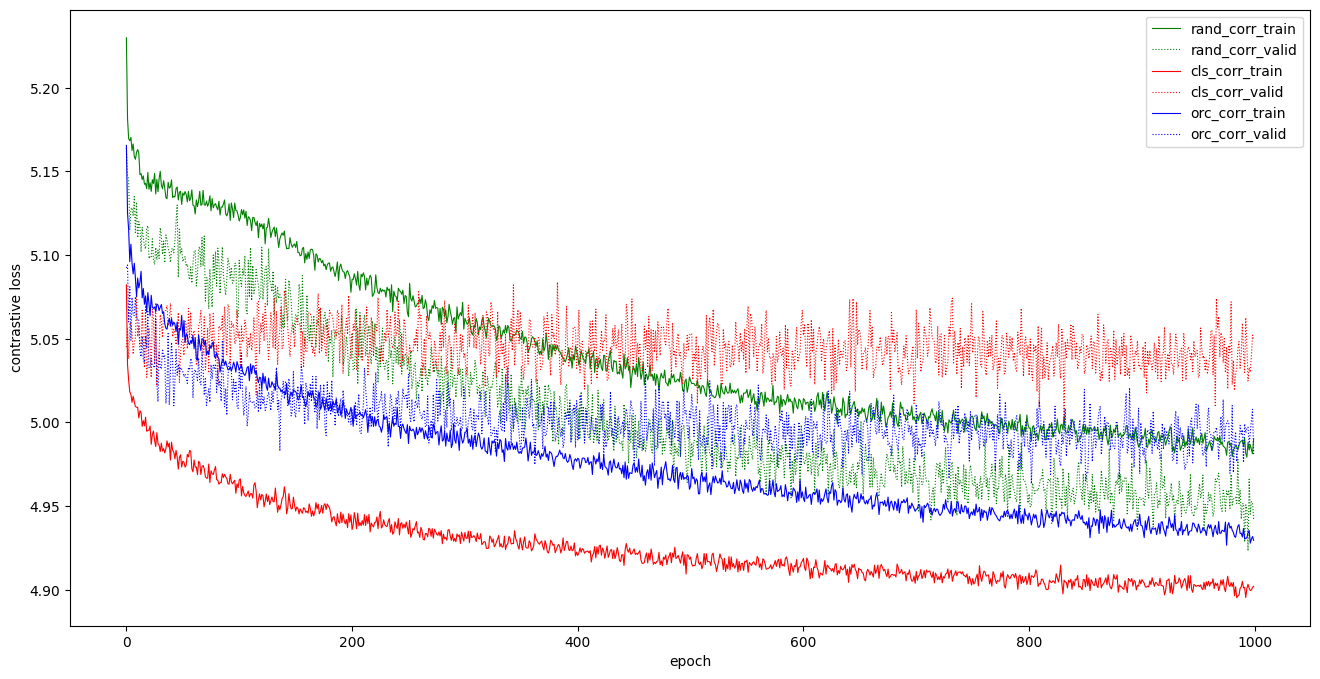

In [9]:
fig, ax = plt.subplots(figsize=(16, 8))
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    ax.plot(loss_histories[key]['train'], label=f'{key}_train', linewidth=0.8, color=plot_colors[key])
    ax.plot(loss_histories[key]['valid'], label=f'{key}_valid', linewidth=0.8, linestyle=':', color=plot_colors[key])
ax.set_xlabel("epoch")
ax.set_ylabel("contrastive loss")
ax.legend()

# Tuning on down-stream task

Supervised learning for orig_input...


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:14<00:00, 13.61it/s]


Supervised learning for rand_corr...


100%|██████████| 200/200 [00:11<00:00, 17.27it/s]


Supervised learning for cls_corr...


100%|██████████| 200/200 [00:12<00:00, 15.40it/s]


Supervised learning for orc_corr...


100%|██████████| 200/200 [00:12<00:00, 15.59it/s]


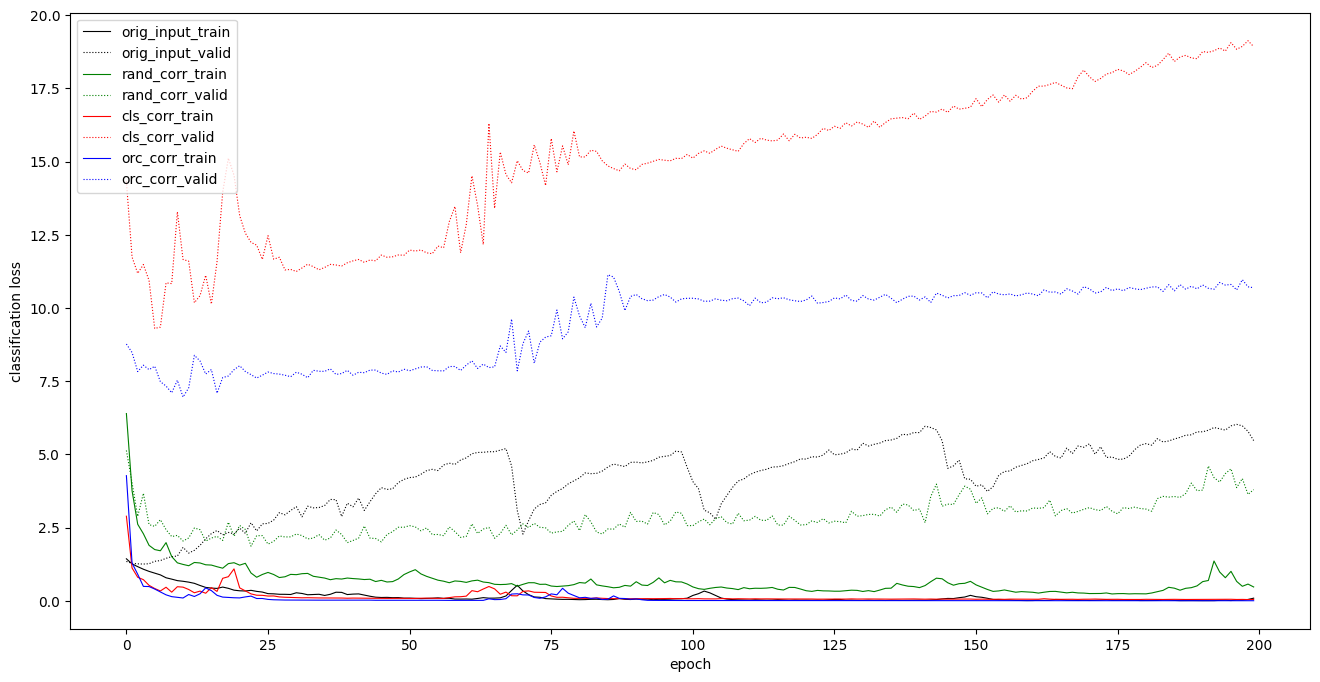

In [10]:
# Take the labeled subset
# Just use a single sampler, would lead to different shuffled order for training data to different models, shouldn't be any essential difference
supervised_sampler = {}
supervised_sampler['train'] = SupervisedSampler(data=train_data[mask_train_labeled], batch_size=batch_size, target=train_target[mask_train_labeled])
supervised_sampler['valid'] = SupervisedSampler(data=valid_data[mask_valid_labeled], batch_size=batch_size, target=valid_target[mask_valid_labeled])

for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    models[key].freeze_encoder()

optimizers, loss_histories = {}, {}
for key in ['orig_input', 'rand_corr', 'cls_corr', 'orc_corr']:
    optimizers[key] = Adam(filter(lambda p: p.requires_grad, models[key].parameters()), lr=0.001)
    loss_histories[key] = {'train': [], 'valid': []}

for key in ['orig_input', 'rand_corr', 'cls_corr', 'orc_corr']:
    print(f"Supervised learning for {key}...")
    train_losses, valid_losses = train_classification(models[key], supervised_sampler, optimizers[key], one_hot_encoder, device, min_epochs=50, early_stopping=False)
    loss_histories[key]['train'] = train_losses
    loss_histories[key]['valid'] = valid_losses

# visualize loss
fig, ax = plt.subplots(figsize=(16, 8))
for key in ['orig_input', 'rand_corr', 'cls_corr', 'orc_corr']:
    ax.plot(loss_histories[key]['train'], label=f'{key}_train', linewidth=0.8, color=plot_colors[key])
    ax.plot(loss_histories[key]['valid'], label=f'{key}_valid', linewidth=0.8, linestyle=':', color=plot_colors[key])
ax.set_xlabel("epoch")
ax.set_ylabel("classification loss")
ax.legend()

In [11]:
# Test the trained classification models
for key in ['orig_input', 'rand_corr', 'cls_corr', 'orc_corr']:
    models[key].eval()
    with torch.no_grad():
        test_prediction_logits = models[key].get_classification_prediction_logits(torch.tensor(one_hot_encoder.transform(test_data), dtype=torch.float32).to(device)).cpu().numpy()
        test_predictions = np.argmax(test_prediction_logits,axis=1)
        print(f"{key} predictions: ", test_predictions)
        print(f"{key} Classification report:")
        print(classification_report(test_target, test_predictions))
        print("Classification accuracy: {:.3f} %".format(np.mean(test_predictions==test_target)*100))
        print("==============================================")


orig_input predictions:  [2 0 4 ... 3 2 1]
orig_input Classification report:
              precision    recall  f1-score   support

           0       0.61      0.65      0.63       548
           1       0.36      0.38      0.37       200
           2       0.47      0.41      0.44       420
           3       0.33      0.30      0.31       217
           4       0.53      0.55      0.54       590

    accuracy                           0.50      1975
   macro avg       0.46      0.46      0.46      1975
weighted avg       0.50      0.50      0.50      1975

Classification accuracy: 50.380 %
rand_corr predictions:  [2 0 2 ... 3 4 0]
rand_corr Classification report:
              precision    recall  f1-score   support

           0       0.58      0.69      0.63       548
           1       0.24      0.23      0.23       200
           2       0.45      0.26      0.33       420
           3       0.33      0.30      0.32       217
           4       0.48      0.57      0.52       590


# Visualize embeddings

In [12]:
# get embeddings for training and test set
train_embeddings, test_embeddings = {}, {}
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    models[key].eval()
    with torch.no_grad():
        train_embeddings[key] = models[key].get_middle_embedding(torch.tensor(one_hot_encoder.transform(train_data), dtype=torch.float32).to(device)).cpu().numpy()
        test_embeddings[key] = models[key].get_middle_embedding(torch.tensor(one_hot_encoder.transform(test_data), dtype=torch.float32).to(device)).cpu().numpy()

# Visualzie using PCA (which supports same basis from training to testing)

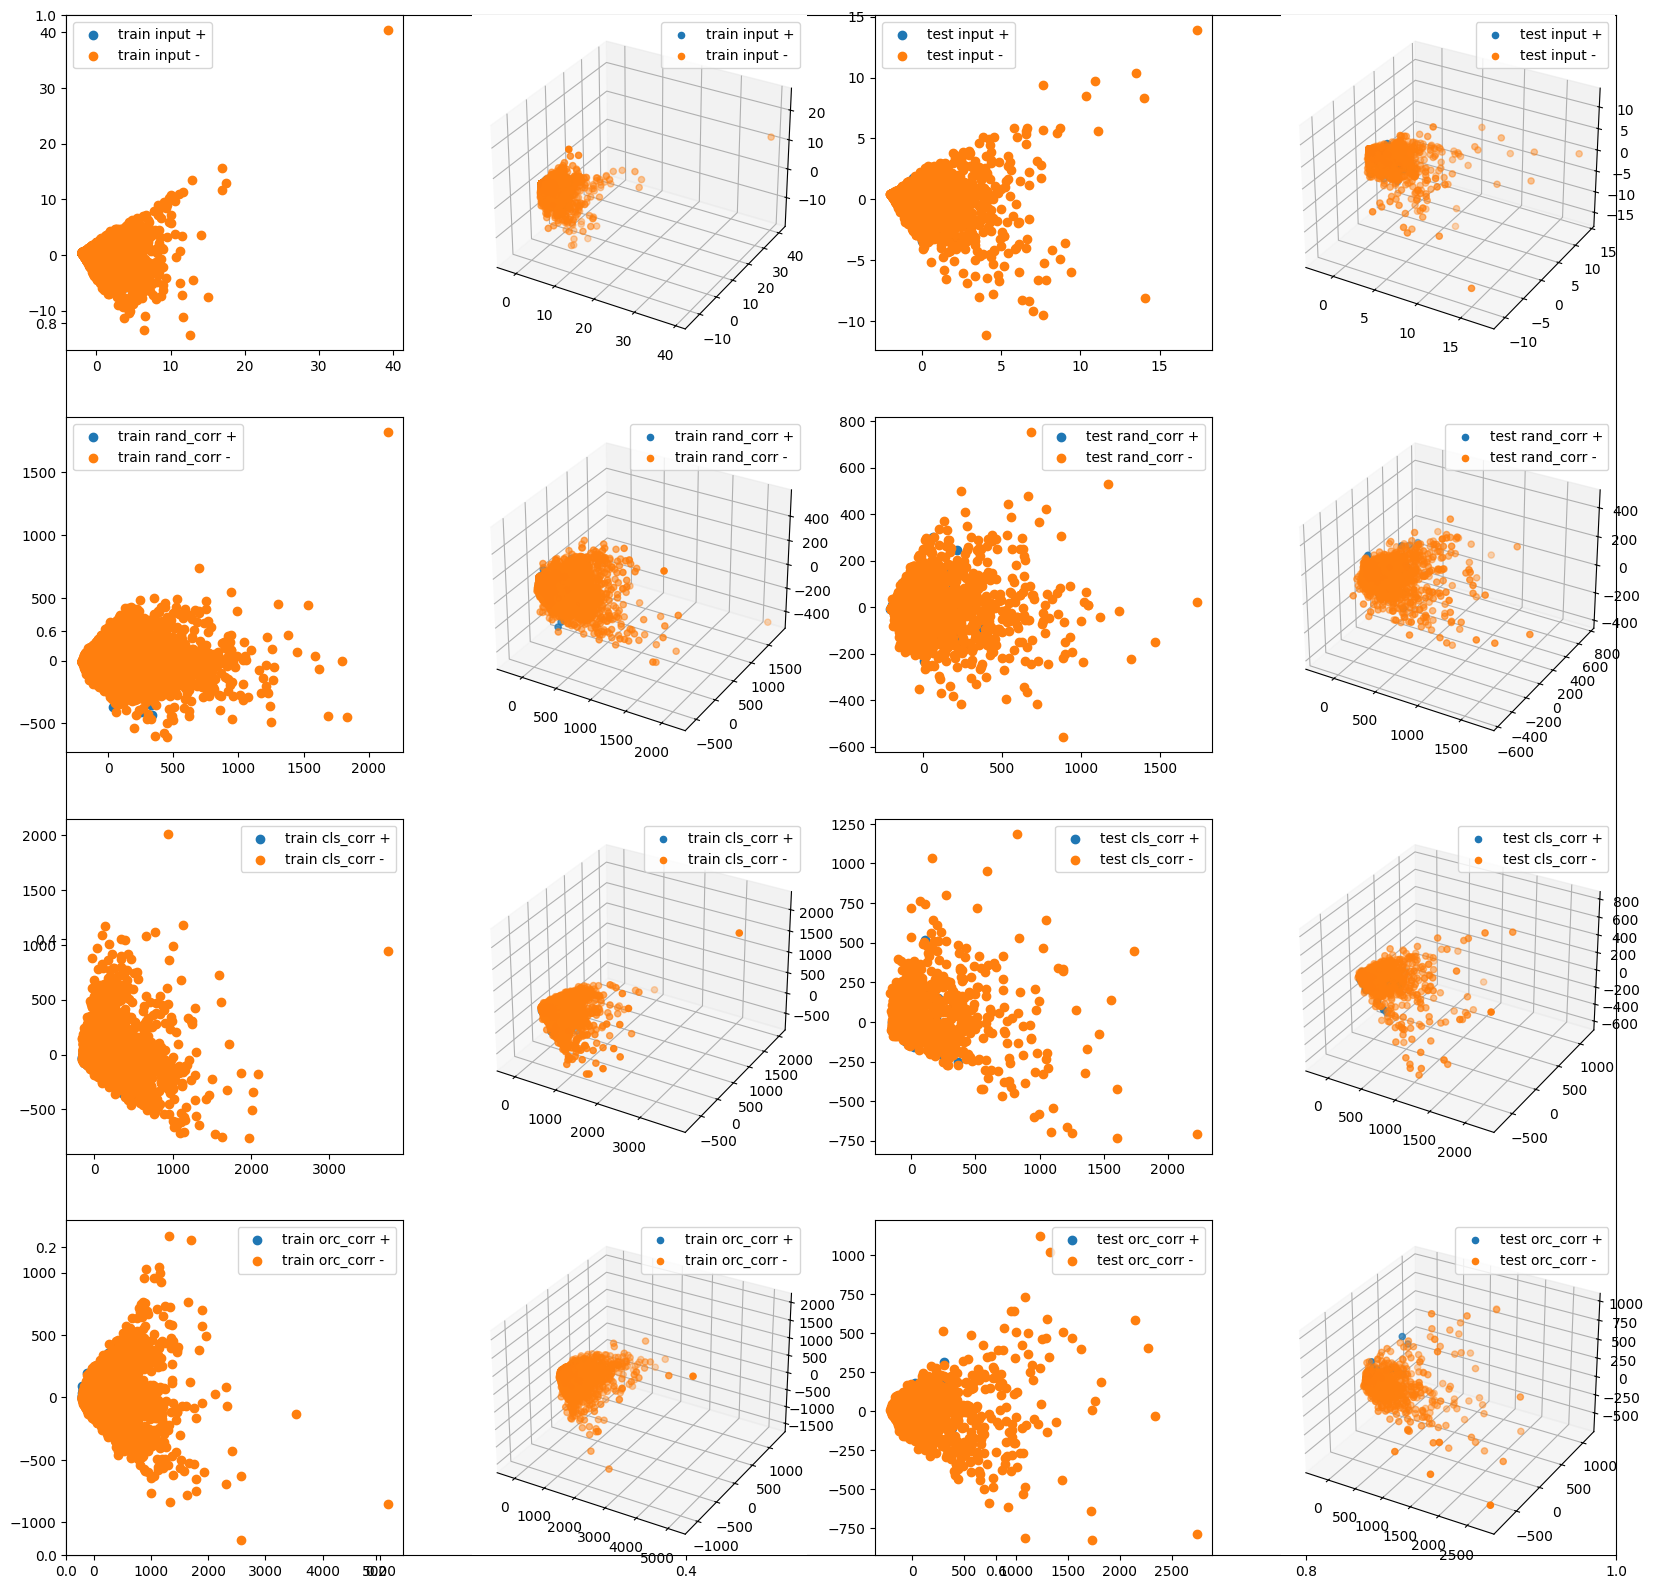

In [13]:
# visualize in 2D
fig, axes = plt.subplots(figsize=(20, 20))

pca_2D = PCA(n_components=2, copy=True)
pca_3D = PCA(n_components=3, copy=True)
# first plot the original input
reduced_2D = pca_2D.fit_transform(one_hot_encoder.transform(train_data))
reduced_3D = pca_3D.fit_transform(one_hot_encoder.transform(train_data))
positive = train_target == 1
ax = fig.add_subplot(4,4,1)
ax.scatter(reduced_2D[positive, 0], reduced_2D[positive, 1], label=f"train input +")
ax.scatter(reduced_2D[~positive, 0], reduced_2D[~positive, 1], label=f"train input -")
ax.legend()
ax = fig.add_subplot(4,4,2, projection='3d')
ax.scatter(reduced_3D[positive, 0], reduced_3D[positive, 1], reduced_3D[positive, 2], label=f"train input +")
ax.scatter(reduced_3D[~positive, 0], reduced_3D[~positive, 1], reduced_3D[~positive,2], label=f"train input -")
ax.legend()
reduced_2D = pca_2D.transform(one_hot_encoder.transform(test_data))
reduced_3D = pca_3D.transform(one_hot_encoder.transform(test_data))
positive = test_target == 1
ax = fig.add_subplot(4,4,3)
ax.scatter(reduced_2D[positive, 0], reduced_2D[positive, 1], label="test input +")
ax.scatter(reduced_2D[~positive, 0], reduced_2D[~positive, 1], label="test input -")
ax.legend()
ax = fig.add_subplot(4,4,4, projection='3d')
ax.scatter(reduced_3D[positive, 0], reduced_3D[positive, 1], reduced_3D[positive, 2], label="test input +")
ax.scatter(reduced_3D[~positive, 0], reduced_3D[~positive, 1], reduced_3D[~positive,2], label="test input -")
ax.legend()


for row_id, key in enumerate(['rand_corr', 'cls_corr', 'orc_corr']):
    reduced_2D = pca_2D.fit_transform(train_embeddings[key])
    reduced_3D = pca_3D.fit_transform(train_embeddings[key])
    positive = train_target == 1
    ax = fig.add_subplot(4,4,(row_id+1)*4+1)
    ax.scatter(reduced_2D[positive, 0], reduced_2D[positive, 1], label=f"train {key} +")
    ax.scatter(reduced_2D[~positive, 0], reduced_2D[~positive, 1], label=f"train {key} -")
    ax.legend()
    ax = fig.add_subplot(4,4,(row_id+1)*4+2, projection='3d')
    ax.scatter(reduced_3D[positive, 0], reduced_3D[positive, 1], reduced_3D[positive, 2], label=f"train {key} +")
    ax.scatter(reduced_3D[~positive, 0], reduced_3D[~positive, 1], reduced_3D[~positive,2], label=f"train {key} -")
    ax.legend()

    reduced_2D = pca_2D.fit_transform(test_embeddings[key])
    reduced_3D = pca_3D.fit_transform(test_embeddings[key])
    positive = test_target == 1
    ax = fig.add_subplot(4,4,(row_id+1)*4+3)
    ax.scatter(reduced_2D[positive, 0], reduced_2D[positive, 1], label=f"test {key} +")
    ax.scatter(reduced_2D[~positive, 0], reduced_2D[~positive, 1], label=f"test {key} -")
    ax.legend()
    ax = fig.add_subplot(4,4,(row_id+1)*4+4, projection='3d')
    ax.scatter(reduced_3D[positive, 0], reduced_3D[positive, 1], reduced_3D[positive, 2], label=f"test {key} +")
    ax.scatter(reduced_3D[~positive, 0], reduced_3D[~positive, 1], reduced_3D[~positive,2], label=f"test {key} -")
    ax.legend()

plt.show()